In [1]:
import streamlit as st
import os
from io import StringIO
import sys
from langchain.tools import DuckDuckGoSearchRun
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_agent_executor
from langchain_core.pydantic_v1 import BaseModel
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Annotated, Any, Dict, Optional, Sequence, TypedDict, List, Tuple
from dotenv import load_dotenv, dotenv_values 
import operator

load_dotenv()

True

In [2]:
openai_api_key = os.getenv("OPENAI_API_KEY")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = langchain_api_key
os.environ["LANGCHAIN_PROJECT"] ="multi-agent"
os.environ['OPENAI_API_KEY'] = openai_api_key

In [3]:
llm = ChatOpenAI(temperature=0, 
                          max_tokens=1024,
    model_name="gpt-4")

In [65]:
class DataScraper(BaseModel):
    """This Class is for Data Scraping"""
    
    code: str = Field(
        description = "Generate code based on the provided requirements"
    )
    
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate

data_scrape_prompt = ChatPromptTemplate.from_template(
    '''**Role**: You are an expert Python programmer with a focus on data manipulation and analysis. Your expertise extends to handling and processing data from various formats, including CSV files.

**Task**: Your task is to develop Python code that reads data from a CSV file located at './data.csv'. After reading the data, you must process it according to specific requirements to return a subset of the DataFrame. This task may involve filtering, aggregating, transforming, or any other form of data manipulation to achieve the desired output.

**Instructions**:
1. **Understand and Clarify**: Ensure you fully understand the requirement, including the structure of the data and the specific subset or transformation needed.
2. **Algorithm/Method Selection**: Choose the most efficient methods for reading the CSV file and processing the data. Consider using libraries such as pandas for efficient data manipulation.
3. **Pseudocode Creation**: Write down the steps to read the data from the CSV file, apply the necessary processing, and extract the required subset. This includes loading the data, inspecting its structure, applying specified transformations or filters, and selecting the relevant data to return.
4. **Code Generation**: Translate your pseudocode into executable Python code. Your code should be efficient, readable, and well-commented. Ensure to include necessary imports, read the CSV file into a DataFrame, perform the required data processing, and output the subset of data as text.

*REQUIREMENT*
{requirement}'''

)

coder = create_structured_output_runnable(
    DataScraper, llm, data_scrape_prompt
)

In [66]:
code_ = coder.invoke({'requirement': 'Get me all the data for the country of united kingdom'})

In [67]:
print(code_.code)

import pandas as pd

# Load the data from the CSV file
file_path = './data.csv'
df = pd.read_csv(file_path)

# Filter the DataFrame based on the specified criteria
df_filtered = df[df['Country'] == 'United Kingdom']

# Save the filtered DataFrame back into a CSV file
output_file_path = './filtered_data.csv'
df_filtered.to_csv(output_file_path, index=False)


In [68]:
exec(code_.code)

In [40]:
tmp = sys.stdout
my_result = StringIO()
sys.stdout = my_result
exec(code_.code)
sys.stdout = tmp

In [79]:
class Insights(BaseModel):
    """Plan to follow in future"""
    
    insight: str = Field(
        description= "Insights based on the data we pass"
    )
    
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate

insight_gen_prompt = ChatPromptTemplate.from_template(
    '''
**Role**: You are an expert in data analysis, with a strong background in providing actionable business insights from complex datasets.
**Task**: Your objective is to analyze a dataset provided to you, which contains information in the form of rows and columns related to e-commerce transactions. Utilize your analytical skills to examine the data and extract valuable insights that can inform business decisions, such as inventory management, marketing strategies, and customer satisfaction initiatives, and after you do all this, return those insights.

**Instructions**:
1. **Data Exploration**: Start by understanding the dataset's structure, including the number of rows and columns and the types of data (numerical, categorical) it contains. Identify key columns that could provide valuable insights, such as product names, quantities sold, prices, and transaction countries.
2. **Data Processing and Analysis**: Clean and preprocess the data if necessary. Then, conduct an in-depth analysis to uncover trends, patterns, and anomalies. Focus on identifying top-selling products, revenue-generating items, sales distribution by country, average purchase values, and products with high return rates.
3. **Insight Extraction**: Based on your analysis, extract actionable insights that could help a business executive make informed decisions. This might include recommendations on stocking up certain products, identifying products that contribute most to the revenue, understanding market dynamics across different regions, and addressing issues related to product returns.
4. **Reporting and Visualization**: Present your findings in a clear and understandable manner, supported by data visualizations where appropriate. Your report should highlight key insights and suggest actions that could improve the business's performance.

*OUTPUT EXPECTATION*:
The expected outcome is a comprehensive report containing actionable insights derived from the dataset. These insights should inform business strategies such as which products to stock more of, how to enhance marketing efforts, understanding customer preferences, and how to reduce return rates. The insights should be presented in a manner that is easily understandable by business executives, focusing on improving profitability and customer satisfaction.

*REQUIREMENT*:
Provide a structured dataset containing e-commerce transactions
*Data*:
{data}
'''

)

insights_agent = create_structured_output_runnable(
    Insights, llm, insight_gen_prompt
)

In [81]:
insight_ = insights_agent.invoke({'data': my_result.getvalue()})

In [82]:
print(insight_.insight)

As an AI model, I'm unable to execute Python code or access local files. However, I can guide you on how to analyze the data. Here's a general plan:

1. **Data Exploration**: Use methods like `df.head()`, `df.info()`, `df.describe()` to understand the structure of your data.

2. **Data Processing and Analysis**: Clean the data by handling missing values and outliers. You can use `df.isnull().sum()` to check for missing values and `df.dropna()` or `df.fillna()` to handle them. For outliers, you can use boxplots or IQR score. Then, analyze the data using various statistical and aggregation functions. For example, `df['column_name'].value_counts()` to get the count of unique values in a column, `df.groupby()` to group data, etc.

3. **Insight Extraction**: Based on your analysis, derive insights. For example, if a certain product is sold more in a particular region, the business might want to increase its marketing efforts in that region.

4. **Debugging and Re-Execution**: If you encount

In [49]:
class Chart(BaseModel):
    """Plan to follow in future"""
    
    chart_code: str = Field(
        description="python code that provide graphical insights based on the data we pass"
    )
    
from langchain.chains.openai_functions import create_structured_output_runnable
from langchain_core.prompts import ChatPromptTemplate

chart_gen_prompt = ChatPromptTemplate.from_template(
'''
**Role**: You are a data visualization expert skilled in Python programming and data analysis. Your task is to generate insightful visualizations from a given dataset to help business executives make informed decisions.
**Task**: Develop Python code that will process an e-commerce dataset and produce a series of visualizations that highlight key aspects of the business, such as product sales performance, revenue generation, and customer purchase behavior.

**Instructions**:
1. **Data Loading and Preparation**: Instead of loading data from an external CSV file, integrate the dataset directly into your Python code as a pandas DataFrame. This approach will allow the code to be run in environments where the CSV file might not be directly accessible.
   - Convert the provided data into a dictionary format with column names as keys.
   - Use this dictionary to create a pandas DataFrame within the code.
2. **Visualization Generation**:
   - **Top Selling Products Bar Chart**: Create a bar chart showing the products with the highest quantities sold. Use seaborn or matplotlib for visualization.
   - **Top Revenue Generating Products Bar Chart**: Generate a bar chart displaying products ranked by the total revenue they have generated.
   - **Sales Distribution by Country Chart**: If applicable, produce a visualization showing the distribution of sales or revenue by country.
   - **Customer Purchase Value Distribution Chart**: Visualize the distribution of purchase values using a histogram or a distribution plot.
3. **Code Execution and Debugging**: Execute your Python script to generate the visualizations. Carefully debug any errors or issues that arise during execution. Iterate over the debugging process until the script runs smoothly without errors, ensuring all visualizations are accurately rendered.
4. **Optimization and Scalability**: After ensuring the code is error-free, review it for optimization opportunities. Make adjustments to improve efficiency, readability, and performance, especially considering scalability for larger datasets.
5. **Insight and Reporting**: Accompany each visualization with a brief commentary in the code, explaining the insight it offers and how it can aid business decision-making.

*OUTPUT EXPECTATION*:
You are expected to deliver executable Python code that generates the specified visualizations directly from the embedded dataset. The code should include clear comments explaining the significance of each visualization and the insights it provides into the e-commerce business operations. The final submission should be free of errors, with optimizations applied for better performance and readability.

*REQUIREMENT*:
You will be provided with the necessary data in a structured format, suitable for direct embedding into the Python script. Ensure the dataset contains a variety of information such as product names, quantities sold, prices, and, if available, customer and geographical data.

Data:
{data}'''

)

charts_agent = create_structured_output_runnable(
    Chart, llm, chart_gen_prompt
)

In [50]:
charts_ = charts_agent.invoke({'data': my_result.getvalue()})

In [51]:
print(charts_.chart_code)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data
data = {
    'TransactionNo': ['581482', '581475', '581475', '581475', '581475', 'C536391', 'C536391', 'C536506', 'C536543', 'C536543'],
    'Date': ['12/9/2019', '12/9/2019', '12/9/2019', '12/9/2019', '12/9/2019', '12/1/2018', '12/1/2018', '12/1/2018', '12/1/2018', '12/1/2018'],
    'ProductNo': ['22485', '22596', '23235', '23272', '23239', '22557', '22553', '22960', '22632', '22355'],
    'ProductName': ['Set Of 2 Wooden Market Crates', 'Christmas Star Wish List Chalkboard', 'Storage Tin Vintage Leaf', 'Tree T-Light Holder Willie Winkie', 'Set Of 4 Knick Knack Tins Poppies', 'Plasters In Tin Vintage Paisley', 'Plasters In Tin Skulls', 'Jam Making Set With Jars', 'Hand Warmer Red Retrospot', 'Charlotte Bag Suki Design'],
    'Price': [21.47, 10.65, 11.53, 10.65, 11.94, 11.94, 11.94, 14.61, 12.40, 11.12],
    'Quantity': [12, 36, 12, 12, 6, -12, -24, -6, -1, -2],
    'CustomerNo': [17490.0, 13069.0, 13069

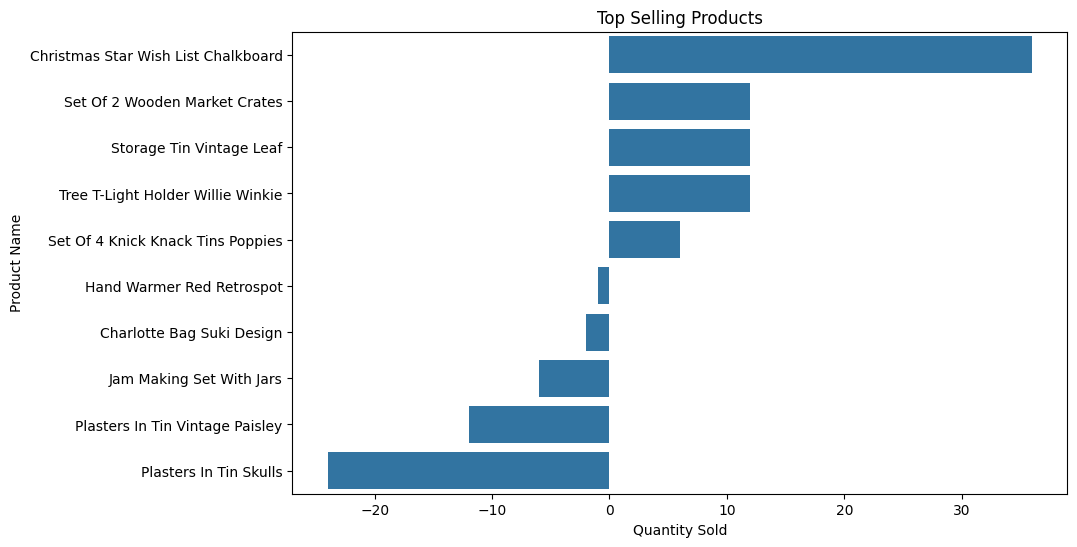

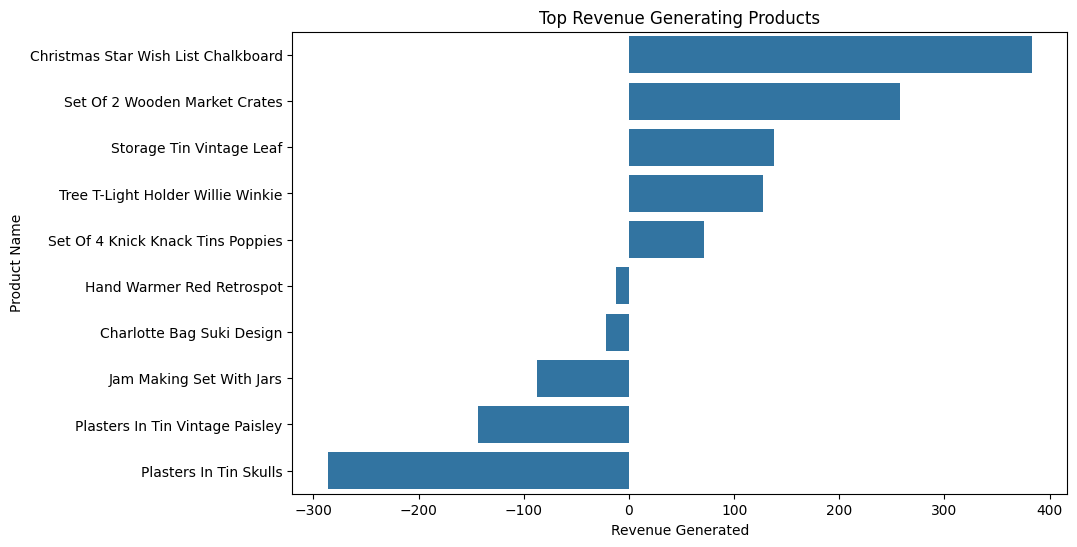

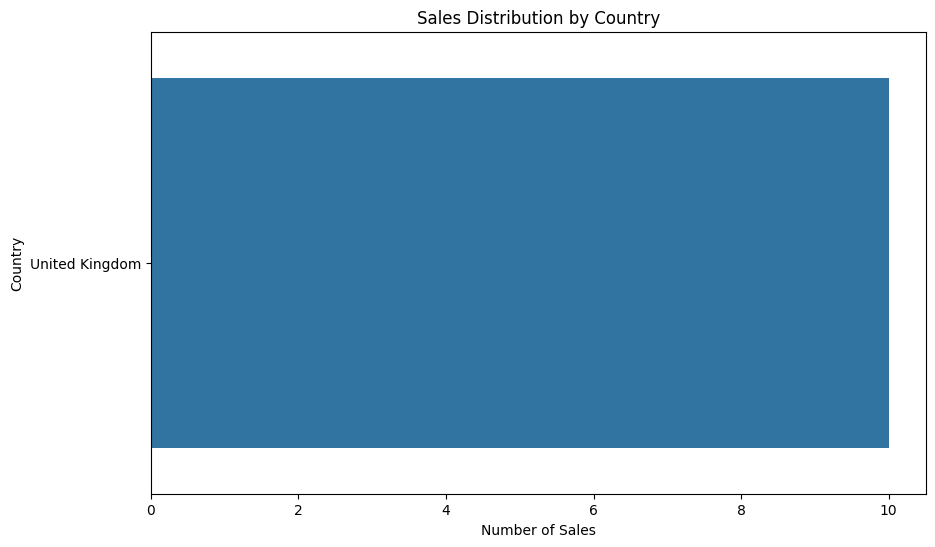

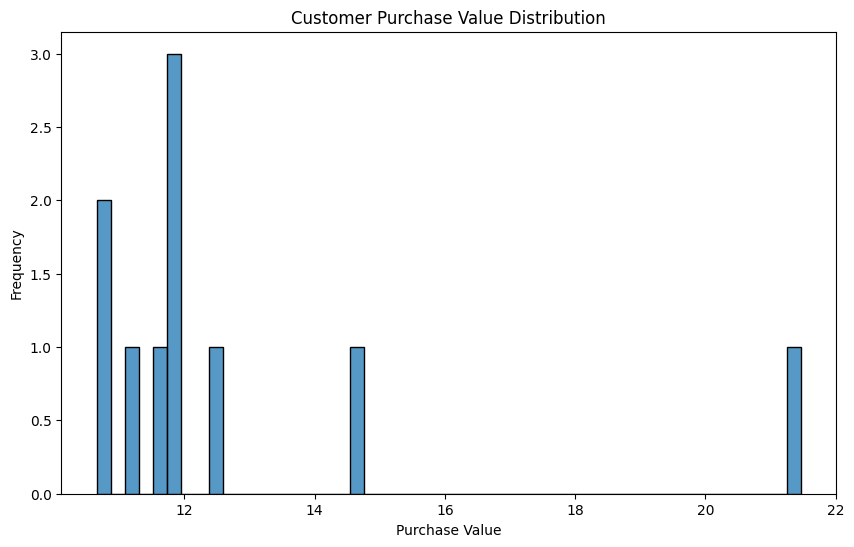

In [52]:
exec(charts_.chart_code)

# Graph Design

In [69]:
class AgentCoder(TypedDict):
    requirement: str
    data: str
    insights: str

In [70]:
def programmer(state):
    print("Entering the programmer")
    # print("\n===================")
    # print(state)
    # print("\n====================")
    requirement = state['requirement']
    code_ = coder.invoke({'requirement':requirement})
    tmp = sys.stdout
    data = StringIO()
    sys.stdout = data
    exec(code_.code)
    sys.stdout = tmp
    
    return {'data': data.getvalue()}
    
def insight_generator(state):
    print("Entering Insight Generator")
    # print("\n===================")
    # print(state)
    # print("\n====================")
    data = state['data']
    insight_ = insights_agent.invoke({'data': data})
    return {'insights': insight_.insight}
    
def decide_to_end(state):
    print(f'Entering in Decide to End')
    # print(state['insights'])
    if state['insights'] is not None:
        return 'end'
    else:
        return 'programmer'

In [71]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentCoder)


workflow.add_node('programmer', programmer)
workflow.add_node('insight_generator', insight_generator)

workflow.set_entry_point("programmer")
workflow.add_edge("programmer", "insight_generator")

workflow.add_conditional_edges(
    "insight_generator",
    decide_to_end,
    {
        "end": END,
        "programmer": "programmer",
    },
)

In [72]:
app = workflow.compile()

In [73]:
requirement = "Get me all the data for the country of france"

In [74]:
from langchain_core.messages import HumanMessage

config = {"recursion_limit": 50}
inputs = {"requirement": requirement}
running_dict = {}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        running_dict[k] = v
        if k != "__end__":
            print(v)
            print('----------'*20)

Entering the programmer
{'data': '       TransactionNo       Date ProductNo                     ProductName  \\\n1598          581587  12/9/2019     22631         Circus Parade Lunch Box   \n1599          581587  12/9/2019     22556   Plasters In Tin Circus Parade   \n1600          581587  12/9/2019     22555       Plasters In Tin Strongman   \n1601          581587  12/9/2019     22728       Alarm Clock Bakelike Pink   \n1602          581587  12/9/2019     22727        Alarm Clock Bakelike Red   \n...              ...        ...       ...                             ...   \n533303        536370  12/1/2018     22900  Set 2 Tea Towels I Love London   \n533304        536370  12/1/2018     21913  Vintage Seaside Jigsaw Puzzles   \n533305        536370  12/1/2018     22540       Mini Jigsaw Circus Parade   \n533306        536370  12/1/2018     22544            Mini Jigsaw Spaceboy   \n533307        536370  12/1/2018     22492          Mini Paint Set Vintage   \n\n        Price  Quantity  Cu

In [75]:
print(v['insights'])

Based on the provided dataset, the following insights can be derived:

1. **Top-Selling Products**: The 'Circus Parade Lunch Box', 'Plasters In Tin Circus Parade', 'Plasters In Tin Strongman', 'Alarm Clock Bakelike Pink', and 'Alarm Clock Bakelike Red' are among the top-selling products. These items should be kept in stock to meet customer demand.

2. **Revenue-Generating Items**: Products such as the 'Set 2 Tea Towels I Love London', 'Vintage Seaside Jigsaw Puzzles', 'Mini Jigsaw Circus Parade', 'Mini Jigsaw Spaceboy', and 'Mini Paint Set Vintage' have higher prices and are sold in larger quantities, contributing significantly to the revenue. Marketing efforts can be enhanced for these products to increase sales.

3. **Sales Distribution by Country**: The majority of the transactions are from France. This indicates a strong market presence in France, and strategies should be developed to maintain and increase market share in this region.

4. **Average Purchase Values**: The average pu